# Analysis of full demolition permits by the City of Austin

- This analysis starts with a file that has been downloaded and processed in another notebook, `01_Download_Process.ipynb`.

## Set up and configurations

In [47]:
import pandas as pd
import altair as alt

## Import file

In [48]:
# Column type fixes
column_types = {
    'ApplicantPhone': pd.np.str,
    'ContractorPhone': pd.np.str,
    'CalendarYearIssued': pd.np.str,
    'OriginalZip': pd.np.str,
}

# import raw data
data_raw = pd.read_csv(
    '../data-processed/residential_demolitions.csv',
    index_col=None,
    dtype=column_types
)

demolitions = data_raw
demolitions.shape

(3169, 67)

## How the number of demolition permits have changed over time

How many demolition permits have been been issued in past years.

### Permits per year

In [49]:
# create data from of permits by year
demos_by_year = demolitions.CalendarYearIssued.value_counts().reset_index()
demos_by_year.columns = ['Year', 'Count']
demos_by_year.sort_values('Year')

,Year,Count
10,2008,110
9,2009,137
8,2010,152
7,2011,176
6,2012,263
4,2013,328
2,2014,357
3,2015,344
1,2016,457
0,2017,567


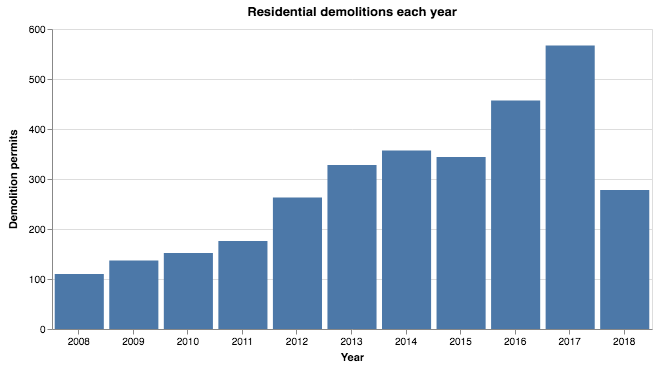

In [50]:
# make chart
alt.Chart(demos_by_year.reset_index(), title="Residential demolitions each year").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Demolition permits")),
).properties(width=600)

### Permits in first half of year

If we want to see how permits are going for 2018, we need to look at the first six months of each year and compare them.

In [51]:
# List to filter for first six months from text string
six_months_list = ['01', '02', '03', '04', '05', '06']

# Make df of first half year permits
# Based on splitting string of date and making sure
# that string is in the list above.
# (another way might be to convert to a date and us `.month`)
six_months_filtered = demolitions[demolitions.IssuedDate.str[5:7].isin(six_months_list)]
six_months_filtered.shape

(1659, 67)

In [52]:
six_months_data = six_months_filtered.CalendarYearIssued.value_counts().reset_index()
six_months_data.columns = ['Year', 'Count']
six_months_data

,Year,Count
0,2017,307
1,2018,278
2,2014,176
3,2013,167
4,2016,161
5,2015,150
6,2012,132
7,2011,84
8,2010,75
9,2009,68


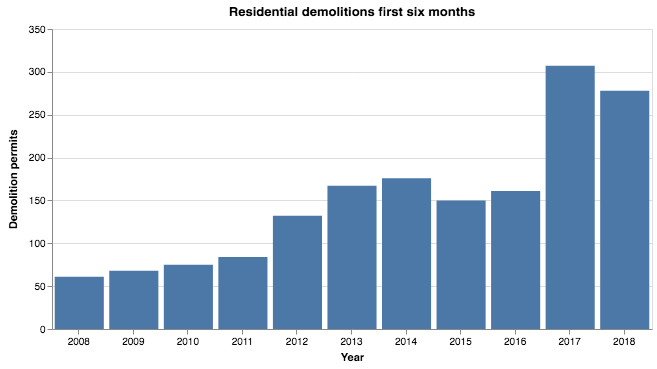

In [53]:
# make chart
alt.Chart(six_months_data.reset_index(), title="Residential demolitions first six months").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q", axis=alt.Axis(title="Demolition permits")),
).properties(width=600)

## Square footage of residential homes demolished

In [54]:
demos_spft = demolitions.groupby('CalendarYearIssued').sum().TotalExistingBldgSQFT.reset_index()
demos_spft.columns = ['Year', 'SqFt']
demos_spft

,Year,SqFt
0,2008,131987.0
1,2009,172399.0
2,2010,197725.0
3,2011,245702.0
4,2012,339043.0
5,2013,294329.0
6,2014,425708.0
7,2015,358905.0
8,2016,676745.0
9,2017,848763.0


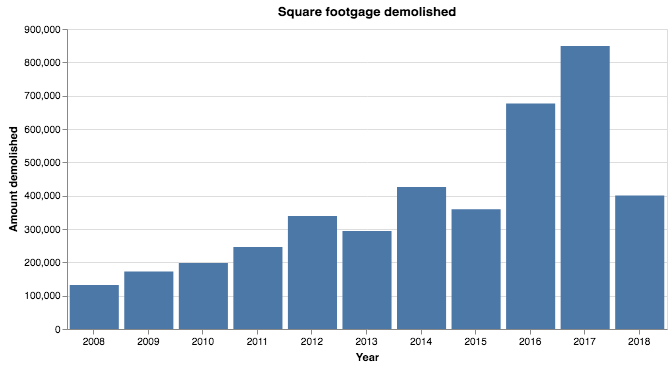

In [55]:
alt.Chart(demos_spft.reset_index(), title="Square footgage demolished").mark_bar().encode(
    x=alt.X("Year:O", axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("SqFt:Q", axis=alt.Axis(title="Amount demolished")),
).properties(width=600)

## Demolitions by Zip code

In [56]:
# make a datafram with counts of permits by zip code
demos_by_zip = demolitions.OriginalZip.value_counts().reset_index()
demos_by_zip.columns = ['Zip', 'Count']
demos_by_zip.head()

,Zip,Count
0,78704,624
1,78702,554
2,78703,370
3,78757,215
4,78731,175


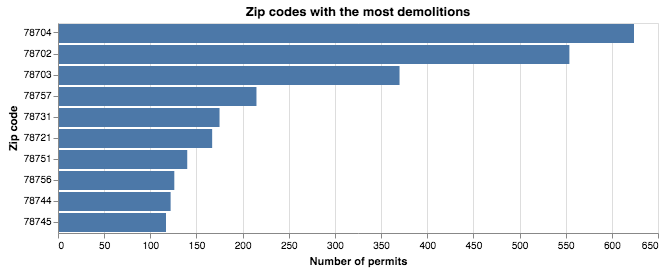

In [57]:
alt.Chart(demos_by_zip.head(10), title="Zip codes with the most demolitions").mark_bar().encode(
    x=alt.X("Count:Q",
            axis=alt.Axis(title="Number of permits")),
    y=alt.Y("Zip:O",
            # this is the sorting magic
            sort=alt.SortField(field="Count", order="descending", op="sum"),
            axis=alt.Axis(title="Zip code")),
).properties(width=600)

## Demolitions by zip code and year

Which parts of town are getting worse?

In [58]:
# Filter out 2018 because it is a partial year
before_2018 = demolitions[demolitions['CalendarYearIssued'] != '2018']

# build a dataframe of yr, zip
demos_yr_zip = before_2018.groupby(['CalendarYearIssued','OriginalZip']).agg(dict(
    PermitNum='count'
)).reset_index()
demos_yr_zip.columns = ['Year', 'Zip', 'Count']
demos_yr_zip.shape
# demos_yr_zip.head()

(260, 3)

In [59]:
# filter to top zips
top_zips = ['78704', '78702', '78703', '78757', '78731',
            '78721', '78751', '78756', '78744', '78745']

top_demos_yr_zip = demos_yr_zip[demos_yr_zip['Zip'].isin(top_zips)]

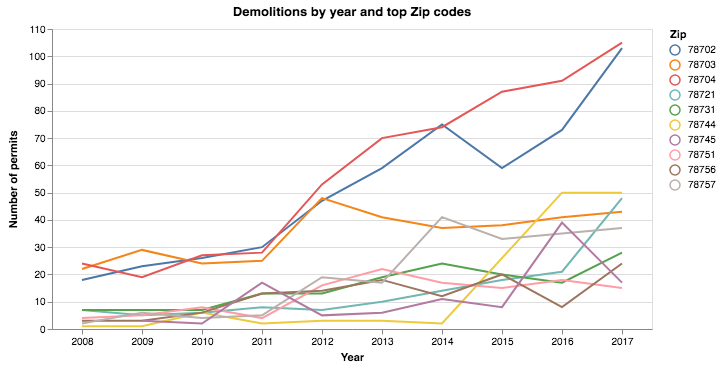

In [60]:
alt.Chart(top_demos_yr_zip, title="Demolitions by year and top Zip codes").mark_line().encode(
    x=alt.X("Year:O",
            axis=alt.Axis(title="Year", labelAngle=0)),
    y=alt.Y("Count:Q",
            axis=alt.Axis(title="Number of permits")),
    color="Zip"
).properties(width=600)

### What's up with 78744, and is 2015 missing?

In [61]:
zip_78744 = demos_yr_zip[demos_yr_zip['Zip'] == '78744']
zip_78744

,Year,Zip,Count
11,2008,78744,1
33,2009,78744,1
59,2010,78744,6
84,2011,78744,2
113,2012,78744,3
137,2013,78744,3
163,2014,78744,2
218,2016,78744,50
248,2017,78744,50


In [76]:
permits_78744 = demolitions[demolitions['OriginalZip'] == '78744']
pd.options.display.max_colwidth = 50
permits_78744[['Description']]

,Description
90,total demo of sf res flood mitigation
91,total demo of sf res flood mitigation
148,total demo of sf res 1978 flood mitigation
179,Total demolition of existing sf res
314,Total demolition of existing SFR City of Austi...
369,Total demolition of existing duplex residence ...
462,total demo of sf res
525,Total demolition of existing SFR City of Austi...
526,Total demolition of existing SFR City of Austi...
542,Total demolition of existing SFR City of Austi...


## References
Ignore this. It's for column references.

In [63]:
demolitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 67 columns):
Unnamed: 0                    3169 non-null int64
PermitType                    3169 non-null object
PermitTypeDesc                3169 non-null object
PermitNum                     3169 non-null object
PermitClassMapped             3169 non-null object
PermitClass                   3169 non-null object
WorkClass                     3169 non-null object
Condominium                   3169 non-null object
ProjectName                   3169 non-null object
Description                   3169 non-null object
TCAD_ID                       3155 non-null object
PropertyLegalDescription      2748 non-null object
AppliedDate                   3169 non-null object
IssuedDate                    3169 non-null object
DayIssued                     3169 non-null object
CalendarYearIssued            3169 non-null object
FiscalYearIssued              3169 non-null int64
IssuedInLast30Days          